# Prepping data

In [1]:
import pandas as pd
import numpy as np
import swifter
from sklearn import metrics

In [4]:
combined_content_df = pd.read_csv('../Datasets/Combined_Dataset/proper_processed_content.csv')
combined_content_df = combined_content_df.dropna()
combined_content_df = combined_content_df.replace(to_replace='None', value=np.nan).dropna()
combined_content_df = combined_content_df[combined_content_df.label != 'label']

combined_content_df.reset_index(drop=True, inplace=True)
combined_content_df['content'] = combined_content_df['content'].astype('string')

combined_content_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 879713 entries, 0 to 879712
Data columns (total 2 columns):
 #   Column   Non-Null Count   Dtype 
---  ------   --------------   ----- 
 0   label    879713 non-null  object
 1   content  879713 non-null  string
dtypes: object(1), string(1)
memory usage: 13.4+ MB


In [4]:
domain_df = pd.read_csv('../Datasets/Combined_Dataset/processed_domain.csv', usecols=['label', 'domain'])
domain_df = domain_df.dropna()
domain_df = domain_df.replace(to_replace='None', value=np.nan).dropna()
domain_df['domain'] = domain_df['domain'].astype('string')
domain_df.reset_index(drop=True, inplace=True)

domain_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4469201 entries, 0 to 4469200
Data columns (total 2 columns):
 #   Column  Dtype 
---  ------  ----- 
 0   label   object
 1   domain  string
dtypes: object(1), string(1)
memory usage: 68.2+ MB


In [5]:
title_df = pd.read_csv('../Datasets/Combined_Dataset/processed_title.csv', usecols=['label', 'title'])
title_df = title_df.replace(to_replace='None', value=np.nan).dropna()
title_df['title'] = title_df['title'].astype('string')
title_df.reset_index(drop=True, inplace=True)

title_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4466123 entries, 0 to 4466122
Data columns (total 2 columns):
 #   Column  Dtype 
---  ------  ----- 
 0   label   object
 1   title   string
dtypes: object(1), string(1)
memory usage: 68.1+ MB


In [9]:
# JUST FOR TESTING

from sklearn.model_selection import train_test_split

train_df, test_df = train_test_split(title_df, test_size=0.3, random_state=42)

X_train = train_df['title']
Y_train = train_df['label']
X_test = test_df['title']
Y_test = test_df['label']

# Modeling

In [2]:
from sklearn.metrics import classification_report,confusion_matrix
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score

def print_metrices(pred,true):
    print(confusion_matrix(true,pred))
    print(classification_report(true,pred,))
    print("Accuracy : ",accuracy_score(pred,true))
    print("Precison : ",precision_score(pred,true, average = 'weighted'))
    print("Recall : ",recall_score(pred,true,  average = 'weighted'))
    print("F1 : ",f1_score(pred,true,  average = 'weighted'))

In [3]:
import matplotlib.pyplot as plt
import itertools

# Applying confusion matrix
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [4]:
import pickle

title_model = pickle.load(open('./models/combined_title_pa_model.sav', 'rb'))
domain_model = pickle.load(open('./models/combined_domain_pa_model.sav', 'rb'))
content_model = pickle.load(open('./models/combined_content_pa_model.sav', 'rb'))

# Testing pipelines to retrieving relevant columns

In [5]:
kaggle_df = pd.read_csv('../Datasets/Combined_Dataset/combined_data.csv')
kaggle_df = kaggle_df.dropna()
kaggle_df = kaggle_df.replace(to_replace='None', value=np.nan).dropna()
kaggle_df.reset_index(drop=True, inplace=True)
kaggle_df = kaggle_df[kaggle_df.label != 'label']

kaggle_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7976 entries, 0 to 7976
Data columns (total 5 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   url      7976 non-null   object
 1   title    7976 non-null   object
 2   content  7976 non-null   object
 3   label    7976 non-null   object
 4   domain   7976 non-null   object
dtypes: object(5)
memory usage: 373.9+ KB


In [6]:
kaggle_df.label.unique()

array(['reliable', 'fake'], dtype=object)

## Defining custom transformer for title, domain and content models

In [7]:
def get_domain(target_df):
    return target_df['domain']

def get_title(target_df):
    return target_df['title']

def get_content(target_df):
    return target_df['content']

get_domain(kaggle_df)

0                 bbc.com
1             reuters.com
2             nytimes.com
3             reuters.com
4                 cnn.com
              ...        
7972    beforeitsnews.com
7973    beforeitsnews.com
7974    beforeitsnews.com
7975          reuters.com
7976    beforeitsnews.com
Name: domain, Length: 7976, dtype: object

In [8]:
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from nltk.tokenize import RegexpTokenizer
import re

ps = PorterStemmer()

def clean_content(series):
    for index, text in series.items(): 
        text = re.sub(r"http\S+", "", text)

        # Tokenize and Remove non alphanumeric characters
        tokenizer = RegexpTokenizer('\w+|\$[\d\.]+|\S+')
        tokens = tokenizer.tokenize(text)
        allalpha_tokens = [word for word in tokens if word.isalpha()]

        # Porter stemmer back to basic english words
        words = [ps.stem(word) for word in allalpha_tokens if not word in stopwords.words('english')]
        words = ' '.join(words)
        series[index] = words
    return series.replace(to_replace='None', value=np.nan).dropna()


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\pluto\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [9]:
from sklearn.preprocessing import FunctionTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline

domain_trans = FunctionTransformer(get_domain)
title_trans = FunctionTransformer(get_title)
content_trans = FunctionTransformer(get_content)
stemmer = FunctionTransformer(clean_content)

pipelined_domain_model = Pipeline([('domain_trans', domain_trans), ('stemming', stemmer), ('domain_model', domain_model)])

pipelined_title_model = Pipeline([('title_trans', title_trans), ('stemming', stemmer), ('title_model', title_model)])

pipelined_content_model = Pipeline([('content_trans', content_trans), ('stemming', stemmer), ('content_model', content_model)])


In [10]:
testpred = pipelined_content_model.predict(kaggle_df)
metrics.accuracy_score(kaggle_df['label'], testpred)

0.9937311935807422

# Stacking PA classifiers together

In [27]:
from sklearn.ensemble import StackingClassifier
from sklearn.neural_network import MLPClassifier

stacked_model = StackingClassifier(
    estimators=[
        ('PA Domain', pipelined_domain_model),
        ('PA Title', pipelined_title_model),
        ('PA Content', pipelined_content_model)
    ],
    final_estimator = MLPClassifier(learning_rate='adaptive', verbose=True, random_state=42),
    cv=5,
    verbose=1,
)

# Fitting Stacked Classifier

In [23]:
from sklearn.model_selection import train_test_split

train_df, test_df = train_test_split(kaggle_df, test_size=0.3, random_state=42)

train_df

,url,title,content,label,domain
2821,http://www.bbc.com/news/world-africa-41558109\n,Liberia votes to choose Ellen Johnson Sirleaf ...,imag caption poor infrastructur may delay vote...,reliable,bbc.com
6117,https://www.reuters.com/article/us-china-wealt...,China's richest man built fortune even as debt...,file photo evergrand group chairman xu jiayin ...,reliable,reuters.com
3123,https://www.reuters.com/article/us-britain-sha...,"Hamlet, Lear line the Thames in London Shakesp...",a pyrotechnician light flame depict william sh...,reliable,reuters.com
589,http://money.cnn.com/2017/10/11/media/politica...,Political point scoring muddies sexual-harassm...,at risk sound hopelessli naiv time put asid po...,reliable,money.cnn.com
4867,http://beforeitsnews.com/sports/2017/10/105-ex...,10/5 Expo Park-Forbes Field: Bucs Win '60 Open...,an embattl pharmaceut compani that sell power ...,fake,beforeitsnews.com
...,...,...,...,...,...
5227,http://www.cnn.com/videos/cnnmoney/2017/10/08/...,Jason Aldean opens 'SNL' with Vegas tribute,countri singer jason aldean perform la vega sh...,reliable,cnn.com
5391,http://beforeitsnews.com/sports/2017/09/acc-ne...,ACC Network headed to Bristol and other ACC Ne...,acc network head bristol acc network note it n...,fake,beforeitsnews.com
860,http://beforeitsnews.com/sports/2017/09/930-ex...,"9/30 Expo Park-Forbes Field Era: Temple Cup, '...",an embattl pharmaceut compani that sell power ...,fake,beforeitsnews.com
7604,http://www.cnn.com/2017/10/08/world/us-turkey-...,United States and Turkey mutually suspend visa...,both unit state turkey suspend non visa servic...,reliable,cnn.com


In [24]:
X_train = train_df.loc[:, train_df.columns != 'label']
Y_train = train_df['label']
X_test = test_df.loc[:, test_df.columns != 'label']
Y_test = test_df['label']

In [25]:
Y_train

2821    reliable
6117    reliable
3123    reliable
589     reliable
4867        fake
          ...   
5227    reliable
5391        fake
860         fake
7604    reliable
7271    reliable
Name: label, Length: 5583, dtype: object

In [26]:
stacked_model = stacked_model.fit(X_train, Y_train)

BrokenProcessPool: A task has failed to un-serialize. Please ensure that the arguments of the function are all picklable.

D:\Python\lib\site-packages\sklearn\preprocessing\_function_transformer.py:171: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return func(X, **(kw_args if kw_args else {}))
Accuracy:    1.0
Confusion matrix, without normalization


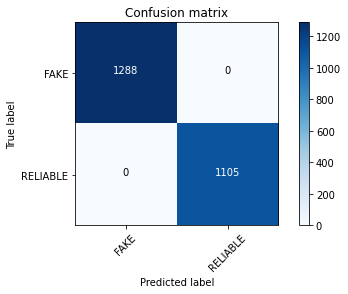

In [93]:
from sklearn import metrics

pred = stacked_model.predict(X_test)
score = metrics.accuracy_score(Y_test, pred)
print("Accuracy:   ", score)
cm = metrics.confusion_matrix(Y_test, pred)
plot_confusion_matrix(cm, classes=['FAKE', 'RELIABLE'])

# Testing data on a 2GB fakenewscorpus

In [16]:
fakenewscorpus_df = pd.read_csv('../Datasets/Combined_Dataset/processed_content.csv')
fakenewscorpus_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 865520 entries, 0 to 865519
Data columns (total 6 columns):
 #   Column   Non-Null Count   Dtype 
---  ------   --------------   ----- 
 0   domain   865520 non-null  object
 1   label    865520 non-null  object
 2   url      865520 non-null  object
 3   content  865519 non-null  object
 4   title    865520 non-null  object
 5   author   865520 non-null  object
dtypes: object(6)
memory usage: 39.6+ MB


In [17]:
fakenewscorpus_df.dropna()
fakenewscorpus_df = fakenewscorpus_df.replace(to_replace='None', value=np.nan).dropna()
fakenewscorpus_df.reset_index(drop=True, inplace=True)

fakenewscorpus_df_nolabel = fakenewscorpus_df.loc[:, fakenewscorpus_df.columns != 'label']
fakenewscorpus_df_labels = fakenewscorpus_df['label']
fakenewscorpus_df_nolabel.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 865519 entries, 0 to 865518
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype 
---  ------   --------------   ----- 
 0   domain   865519 non-null  object
 1   url      865519 non-null  object
 2   content  865519 non-null  object
 3   title    865519 non-null  object
 4   author   865519 non-null  object
dtypes: object(5)
memory usage: 33.0+ MB


In [18]:
fakenewscorpus_pred = stacked_model.predict(fakenewscorpus_df_nolabel)
fakenewscorpus_score = metrics.accuracy_score(fakenewscorpus_df_labels, fakenewscorpus_pred)
print("Accuracy:   ", fakenewscorpus_score)
fakenewscorpus_cm = metrics.confusion_matrix(fakenewscorpus_df_labels, fakenewscorpus_pred)
plot_confusion_matrix(fakenewscorpus_cm, classes=['FAKE', 'RELIABLE'])

D:\Python\lib\site-packages\sklearn\preprocessing\_function_transformer.py:171: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return func(X, **(kw_args if kw_args else {}))


KeyboardInterrupt: 

In [21]:
import pickle

filename = 'stacked_classifier.sav'
pickle.dump(stacked_model, open(filename, 'wb'))

print("Done saving model")

Done saving model


In [28]:
saved_stack_model = pickle.load(open('stacked_classifier.sav', 'rb'))

In [29]:
pred = saved_stack_model.predict(X_test)
score = metrics.accuracy_score(Y_test, pred)
print("Accuracy:   ", score)

D:\Python\lib\site-packages\sklearn\preprocessing\_function_transformer.py:171: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return func(X, **(kw_args if kw_args else {}))
Accuracy:    1.0


In [30]:
sampled_corpus_df = fakenewscorpus_df.sample(frac=0.2)

In [31]:
sampled_corpus_df_nolabel = sampled_corpus_df.loc[:, sampled_corpus_df.columns != 'label']
sampled_corpus_df_label = sampled_corpus_df['label']

In [ ]:
test_pred = saved_stack_model.predict(sampled_corpus_df_nolabel)
test_score = metrics.accuracy_score(sampled_corpus_df_label, test_pred)
print("Accuracy:   ", test_score)
test_cm = metrics.confusion_matrix(sampled_corpus_df_label, test_pred)
plot_confusion_matrix(test_cm, classes=['FAKE', 'RELIABLE'])